# [TK] Algorytm ewolucyjny w modelu wyspowym
Autorzy: _Kasper Kądzielawa_ i _Wiktor Reczek_

## Wstęp
Efektem naszych prac jest generyczny framework do pisania i uruchamiania algorytmów genetycznych w modelu wyspowym.
Produkt wykonaliśmy w języku Kotlin, używając kotlin-coroutines.
Była to dla nas okazja, by poznać ten język i mechanizmy jakie ma do zaoferowania.

## Opis produktu
Nasz framework ma umożliwiać prostą implementację i uruchomienie większości algorytmów genetycznych w modelu wyspowym.
Użytkownik implementuje poszczególne kroki algorytmu generycznego, podaje ilość wysp na jakich mają dziać się obliczenia, a następnie uruchamia obliczenia.
Należy również zaimplementować model, któy będzie podlagał ewolucji.

### Model
#### Entity
Model ewolucyjny powinien implementować interfejs `Entity` (jest to jak narazie interfejs pusty, używany w ograniczeniach typów generycznych).
Klasa ta powinna zawierać genotyp/fenotyp obiektu który będzie mógł podlegać ewolucji.

#### Evaluated entity
Model zewaluowanego obiektu zawiera dany obiekt (kompozycja) oraz dodatkowe pola (metryki ewaluacji).
Na podstawie metryk można w różnych częściach algorytmu podejmować decyzje (np. czy dany obiekt ma przeżyć)
Osobny obiekt istnieje, aby oddzielić dane zewaluowane od genotypu oraz unikać wielokrotnego, potencjalnie czasochłonnego ewaluowania obiektu.

#### Hyperparameters
Aby sterować zachowaniem i parametrami algorytmu, należy rozszerzyć klasę bazową `HyperParameters`.
Zawiera ona podstawowy i uniwersalnuy zestaw pól, który w miarę potrzeb możemy rozszerzać.
obiekt tej klasy dostępny jest na każdym etapie obliczeń.

### Poszczególne kroki
_W listingach widoczne jedynie metody abstakcyjne, które należy zaimplementować._
#### PopulationInitializer
```kotlin
abstract class PopulationInitializer<E : Entity, H : Hyperparameters>(val hyperparameters: H, val reporter: Reporter) {
    protected abstract fun initializeEntity(): E
}
```
Klasa bazowa, której zadaniem jest zainicjalizowanie populacji na każdej z wysp.
Metoda `initializeEntity()` powinna tworzyć pojedynczy obiekt modelu.

#### PopulationEvaloator
```kotlin
abstract class PopulationEvaluator<E : Entity, F : EvaluatedEntity<E>, H : Hyperparameters>(
    val hyperparameters: H,
    val reporter: Reporter
) {
    protected abstract fun evaluateEntity(entity: E): F
}
```
Klasa bazowa, której zadaniem jest ewaluacja każdego obiektu.
Należy zaimplenentować ewaluację pojedynczego obiektu

#### PopulationSelector
```kotlin
abstract class PopulationSelector<E : Entity, F : EvaluatedEntity<E>, H : Hyperparameters>(
    val hyperparameters: H,
    val reporter: Reporter
) {
    abstract fun selectPopulation(evaluatedPopulation: EvaluatedPopulation<E, F>): EvaluatedPopulation<E, F>
}
```
Klasa bazowa, której zadaniem jest wybór osobników, które przetrwają do następnej iteracji.

#### PopulationRecombinator
```kotlin
abstract class PopulationRecombinator<E : Entity, F : EvaluatedEntity<E>, H : Hyperparameters>(
    val hyperparameters: H,
    val reporter: Reporter
) {
    protected abstract fun selectPopulationToBeRecombined(evaluatedPopulation: EvaluatedPopulation<E, F>): Population<E>
    protected abstract fun recombineSelectedPopulation(population: Population<E>): Population<E>
}
```
Klasa bazowa, której zadaniem jest przeprowadzenie procedury rekombinacji osobników, a wcześniej wyboru rodziców.
Istnieją jej dwie szczególne rozszerzenia.

##### CouplePopulationRecombinator
```kotlin
abstract class CouplePopulationRecombinator<E : Entity, F : EvaluatedEntity<E>, H : Hyperparameters>(
    hyperparameters: H,
    reporter: Reporter
) : PopulationRecombinator<E, F, H>(hyperparameters, reporter) {
    
    protected abstract fun recombineCouple(entity1: E, entity2: E): Collection<E>
}
```
Rekombinacja w parach, łączonych losowo.

##### SinglePopulationRecombinator
```kotlin
abstract class SinglePopulationRecombinator<E : Entity, F : EvaluatedEntity<E>, H : Hyperparameters>(
    hyperparameters: H,
    reporter: Reporter
) : PopulationRecombinator<E, F, H>(hyperparameters, reporter) {
    
    protected abstract fun recombineSingle(entity: E): Collection<E>
}
```
Rekombinacja pojedynczego osobnika.

Można implementować też inne - własne wersje rekombinacji.

#### PopulationMutator
```kotlin
abstract class PopulationMutator<E : Entity, F : EvaluatedEntity<E>, H : Hyperparameters>(
    val hyperparameters: H,
    val reporter: Reporter
) {
    protected abstract fun mutateEntity(entity: E): E
}
```
Klasa bazowa, odpowiedzialna za mutowanie osobników.
Należy zaimplementować mutację pojedynczego osobnika.

#### PopulationMigrator
```kotlin
abstract class PopulationMigrator<E : Entity, F : EvaluatedEntity<E>, H : Hyperparameters>(
    val hyperparameters: H,
    val reporter: Reporter,
    private val immigrantsChannel: ReceiveChannel<MigrationMessage<E>>,
    private val emigrantsChannel: SendChannel<MigrationMessage<E>>
) {
    protected abstract fun shouldMigrate(
        iterationCount: Int,
        semiEvaluatedPopulation: SemiEvaluatedPopulation<E, F>
    ): Boolean

    protected abstract fun selectEmigrants(population: SemiEvaluatedPopulation<E, F>): MigrationSelection<E>
```
Klasa odpowiedzialna za przeprowadzanie migracji osobników pomiędzy wyspami.
Należy zaimpelementować warunek migracji `shouldMigrate()` oraz wybór migrantów i osobników którzy zostają `selectEmigrants()`

#### IterationReporter
```kotlin
abstract class IterationReporter<E : Entity, F : EvaluatedEntity<E>, H : Hyperparameters>(
    val hyperparameters: H,
    val reporter: Reporter
) {
    abstract suspend fun report(iterationCount: Int, evaluatedPopulation: EvaluatedPopulation<E, F>)
}
```
Klasa bazowa, której metoda uruchamiana jest co iterację.
Umożliwia to na przykład rejestrowanie metryk co iteracjię, lub logowanie co konkretną liczbę iteracji.

#### StopCondition
```kotlin
abstract class StopCondition<E : Entity, F : EvaluatedEntity<E>, H : Hyperparameters>(
    val hyperparameters: H,
    val reporter: Reporter
) {
    abstract fun shouldStop(iterationCount: Int, evaluatedPopulation: EvaluatedPopulation<E, F>): Boolean
    abstract fun shouldAllStop(iterationCount: Int, evaluatedPopulation: EvaluatedPopulation<E, F>): Boolean
}
```
Klasa bazowa, której działanie determinuje koniec działania algorytmu.
`shouldStop()` mówi o tym, czy dany aktor powinien przestać działać.
`shouldAllStop()` mówi o tym, czy wszyscy aktorzy powinni przestać działać (np. dla tego że znalezionon najlepsze możliwe rozwiązanie) - działanie reszty aktorów jest wtedy anulowane.

#### ResultHandler
```kotlin
abstract class ResultHandler<E : Entity, F : EvaluatedEntity<E>, H : Hyperparameters>(
    val hyperparameters: H,
    val reporter: Reporter
) {
    abstract fun selectResults(
        results: EvaluatedPopulation<E, F>
    ): Collection<F>
}
```
Po zakończeniu obliczeń przez aktora, ten wysyła wyniki do aktora nadzorującego.
Powyższa klasa ma wybierać finalne wyniki, które powinny zostać wysłane.

### Migracja pomiędzy wyspami
Migracja pomiędzy wyspami występuje zgodnie z zaimpelentowanymi warunkami migracji.
Domiślnie jest zaimplementowana topologia pierścienia - każdy aktor wysyła migrantów do jednego sąsiada.
Tak na prawdę, to aktor wysyła migrantów do dodatkowego aktora - routera, który jest odpowiedzialny za przekazanie migrantów dalej.

Gdy dany aktor zakończy działanie, przechodzi do stanu _"preźroczystego"_ w którym przekazuje wszystkich imigrantów dalej.
Umożliwia to dokończenie działania innym aktorom bez błędów związanych z migracjami.
W ostateczności, gdyby w działaniu pozostał ostatni aktor, wszyscy migranci w końcu do niego powrócą.
W tych przypadkach, potencjalnie możliwy jest scenariusz w którym możemy zgubić jakieś obiekty.
Należałoby więc zaimplementować _"odzyskiwanie"_ migrantów z kanałów aby tego uniknąć.
Taki scenariusz jednak nie występuje przy testowanych symulacjach.

### Metryki i logowanie
Podczas działania algorytmu, na każdym jego etapie istnieje dostęp do obiektu, służącego do komunikacji ze specjalnym aktorem.
Aktor ten odpowiedzialny jest za zbieranie informacji o metrykach wykonania algorytmu oraz zwykłych logów.

Po zakończeniu działania algorytmu, dane z metryk są agregowane i wypisywane do pliku `.csv`, co umożliwia prostą wizualizację wyników w wielu dostępnych narzędziach.

Logi zbierane podczas działana algorytmu są od razu wypisywane na ekran, co powinno być nieco bardziej optymalną opcją niż wypisywanie na ekran logów przez każdą z korutyn.
Można ten mechanizm też zaimplementować tak, ze logi będą zbierane i wypisywane w batchach lub zbierane w pamięci i wypisywane na koniec działania programu.
Mechanizm ten miał jedna umożliwić wgląd w postęp i status algorytmu.

#### Przykład implementacji raporowania stanu algorytmu QueensPuzzle
```kotlin
class QueensIterationReporter(hyperparameters: QueensHyperparameters, reporter: Reporter) :
    IterationReporter<Queens, EvaluatedQueens, QueensHyperparameters>(hyperparameters, reporter) {

    override suspend fun report(
        iterationCount: Int,
        evaluatedPopulation: EvaluatedPopulation<Queens, EvaluatedQueens>
    ) {
        val results = evaluatedPopulation.evaluatedEntities.map { it.fitness }
        val best = results.min()
        val mean = results.average()

        reporter.metric("best", best)
        reporter.metric("mean", mean)

        if (iterationCount % 100 == 0) {
            reporter.log("Best=$best; Mean=$mean")
        }
    }
}
```

## Zaimplementowane algorytmy
Używając frameworka, udało nam się zaimplementować oraz rozwiązać dwa problemy.
Dokładną implementację poszczególnych kroków móżna znaleźć w kodzie.
Widać, że nasz framework może posłużyć do implementacji różnego rodzaji algorytmów.

### OneMax
Zadaniem algorytmu jest ewolucja i znalezienie wektora binarnego z maksymalną liczbą jedynek.

#### Implementacja modelu
```kotlin
class BinaryVector(val genes: IntArray) : Entity

class EvaluatedBinaryVector(entity: BinaryVector, val numberOfOnes: Int) : EvaluatedEntity<BinaryVector>(entity) {
    override fun toString(): String {
        return "EvaluatedBinaryVector(numberOfOnes=$numberOfOnes)"
    }
}

class OneMaxHyperparameters(
    maxIterationsCount: Int,
    initialPopulationSize: Int,
    mutationRate: Double,
    val vectorSize: Int,
    val deathRate: Double,
    val reproductionRate: Double,
    val mutationMaxScope: Double,
    val migrationRate: Double,
    val iterationsCountBetweenMigrations: Int,
    val minimalPopulationSize: Int
) : Hyperparameters(maxIterationsCount, initialPopulationSize, mutationRate)
```

#### Uruchomienie algorytmu
```kotlin
val hyperparameters = OneMaxHyperparameters(
        maxIterationsCount = 1000,
        initialPopulationSize = 1000,
        vectorSize = 100,
        deathRate = 0.3,
        reproductionRate = 0.3 / 0.7,
        migrationRate = 0.1,
        mutationMaxScope = 0.05,
        mutationRate = 0.5,
        iterationsCountBetweenMigrations = 10,
        minimalPopulationSize = 2
    )

    val supervisorActor = SupervisorActor(
        hyperparameters,
        { h, r -> OneMaxPopulationInitializer(h, r) },
        { h, r -> OneMaxPopulationEvaluator(h, r) },
        { h, r -> OneMaxStopCondition(h, r) },
        { h, r -> OneMaxPopulationSelector(h, r) },
        { h, r -> OneMaxPopulationRecombinator(h, r) },
        { h, r -> OneMaxPopulationMutator(h, r) },
        { h, r, c1, c2 -> OneMaxPopulationMigrator(h, r, c1, c2) },
        { h, r -> OneMaxResultHandler(h, r) },
        { h, r -> OneMaxIterationReporter(h, r) }
    )

    runBlocking {
        supervisorActor.runSimulation(islandsCount = 5) { results ->
            results
                .sortedByDescending { it.numberOfOnes }
                .forEach { println(it) }
        }
    }
```

### QueensPuzzle
Zadaniem algorytmu jest znalezienie takiego ułożenia królowych na szachownicy, aby żadna żadnej nie biła.

#### Implementacja modelu
```kotlin
class Queens(val positions: Set<Position>, private val boardSize: Int) : Entity {

    override fun toString(): String {
        return buildString {
            for (row in 0 until boardSize) {
                for (col in 0 until boardSize) {
                    val char = if (positions.contains(Position(row, col))) 'Q' else '.'
                    append(char)
                }
                this.appendln()
            }
        }
    }

}

class EvaluatedQueens(entity: Queens, val fitness: Int) : EvaluatedEntity<Queens>(entity)

class QueensHyperparameters(
    maxIterationsCount: Int,
    initialPopulationSize: Int,
    mutationRate: Double,
    val deathRate: Double,
    val reproductionRate: Double,
    val migrationRate: Double,
    val iterationsCountBetweenMigrations: Int,
    val minimalPopulationSize: Int,
    val maxNumberOfQueensToMutate: Int,
    val tournamentSize: Int,
    val boardSize: Int
) : Hyperparameters(maxIterationsCount, initialPopulationSize, mutationRate)
```

#### Uruchomienie algorytmu
```kotlin
val hyperparameters = QueensHyperparameters(
    maxIterationsCount = 10000,
    initialPopulationSize = 100,
    deathRate = 0.3,
    reproductionRate = 0.3 / 0.7,
    migrationRate = 0.1,
    mutationRate = 0.5,
    iterationsCountBetweenMigrations = 20,
    minimalPopulationSize = 2,
    maxNumberOfQueensToMutate = 2,
    tournamentSize = 10,
    boardSize = 8
)

val supervisorActor = SupervisorActor(
    hyperparameters,
    { h, r -> QueensPopulationInitializer(h, r) },
    { h, r -> QueensPopulationEvaluator(h, r) },
    { h, r -> QueensStopCondition(h, r) },
    { h, r -> QueensPopulationSelector(h, r) },
    { h, r -> QueensPopulationRecombinator(h, r) },
    { h, r -> QueensPopulationMutator(h, r) },
    { h, r, c1, c2 -> QueensPopulationMigrator(h, r, c1, c2) },
    { h, r -> QueensResultHandler(h, r) },
    { h, r -> QueensIterationReporter(h, r) }
)

runBlocking {
    supervisorActor.runSimulation(islandsCount = 5) { results ->
        results
            .sortedBy { it.fitness }
            .take(5)
            .forEach {
                println(it.entity)
                println("F = ${it.fitness}")
            }
    }
}
```

#### Przykładowe wyniki
```
.Q......
...Q....
.......Q
.....Q..
......Q.
..Q.....
Q.......
....Q...
```

```
.Q......
..Q.....
......Q.
...Q....
.....Q..
Q.......
.......Q
....Q...
```

```
...Q....
Q.......
..Q.....
......Q.
....Q...
.Q......
.......Q
.....Q..
```

```
.Q......
..Q.....
Q.......
.....Q..
...Q....
......Q.
....Q...
.......Q
```

```
...Q....
.....Q..
.......Q
..Q.....
Q.......
......Q.
....Q...
.Q......
```

## Analiza działania różnych komponentów

In [1]:
%matplotlib inline
import pandas as pd
from pylab import rcParams
from matplotlib import pyplot as plt

In [2]:
fig_width, fig_height = 16, 8
rcParams['figure.figsize'] = fig_width, fig_height

In [3]:
def __my_flatten_cols(self, how="_".join, reset_index=True):
    how = (lambda iter: list(iter)[-1]) if how == "last" else how
    self.columns = [how(filter(None, map(str, levels))) for levels in self.columns.values] \
                    if isinstance(self.columns, pd.MultiIndex) else self.columns
    return self.reset_index() if reset_index else self
pd.DataFrame.my_flatten_cols = __my_flatten_cols

In [4]:
def load_dataset(name):
    df = pd.read_csv(f'metrics_{name}.csv')
    return df

## Tournament selection vs truncation selection (best n) [QueensPuzzle]

### Truncation selection
```kotlin
class QueensPopulationSelector(hyperparameters: QueensHyperparameters, reporter: Reporter) :
    PopulationSelector<Queens, EvaluatedQueens, QueensHyperparameters>(hyperparameters, reporter) {

    override fun selectPopulation(evaluatedPopulation: EvaluatedPopulation<Queens, EvaluatedQueens>): EvaluatedPopulation<Queens, EvaluatedQueens> {
        val numberOfEntitiesToDie = evaluatedPopulation.size * hyperparameters.deathRate

        val survivedEntities = evaluatedPopulation.evaluatedEntities
            .sortedBy { it.fitness }
            .take((evaluatedPopulation.size - numberOfEntitiesToDie).roundToInt())

        return EvaluatedPopulation(survivedEntities)
    }
}
```

### Tournament selection
```kotlin
class QueensTournamentPopulationSelector(hyperparameters: QueensHyperparameters, reporter: Reporter) :
    PopulationSelector<Queens, EvaluatedQueens, QueensHyperparameters>(hyperparameters, reporter) {

    override fun selectPopulation(evaluatedPopulation: EvaluatedPopulation<Queens, EvaluatedQueens>): EvaluatedPopulation<Queens, EvaluatedQueens> {
        val numberOfEntitiesToLive = evaluatedPopulation.size * (1 - hyperparameters.deathRate)

        val entitiesPool = evaluatedPopulation.evaluatedEntities.toMutableList()
        val selectedEntities = mutableListOf<EvaluatedQueens>()

        while (selectedEntities.size < numberOfEntitiesToLive) {
            val winner: EvaluatedQueens? = entitiesPool
                .takeRandom(hyperparameters.tournamentSize)
                .minBy { it.fitness }

            if (winner != null) {
                selectedEntities.add(winner)
                entitiesPool.remove(winner)
            }
        }

        return EvaluatedPopulation(selectedEntities)
    }
}
```

In [5]:
def selection_analysis():
    todf = load_dataset('queens_tournament_5i')
    todf['type'] = 'tournament'
    trdf = load_dataset('queens_trunc_5i')
    trdf['type'] = 'truncation'
    
    islands = [0, 1, 2, 3, 4]
    nrows =  len(islands)
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(fig_width, fig_height * nrows))
    fig.suptitle('Tournament vs truncation selection', fontsize=16)
    fig.subplots_adjust(top=.965)
    
    for i in islands:
        todf[todf.islandId == i].plot(x='iteration', y=['best', 'mean'], ax=ax[i, 0], title=f'Tournament: island {i}')
        trdf[trdf.islandId == i].plot(x='iteration', y=['best', 'mean'], ax=ax[i, 1], title=f'Truncation: island {i}')

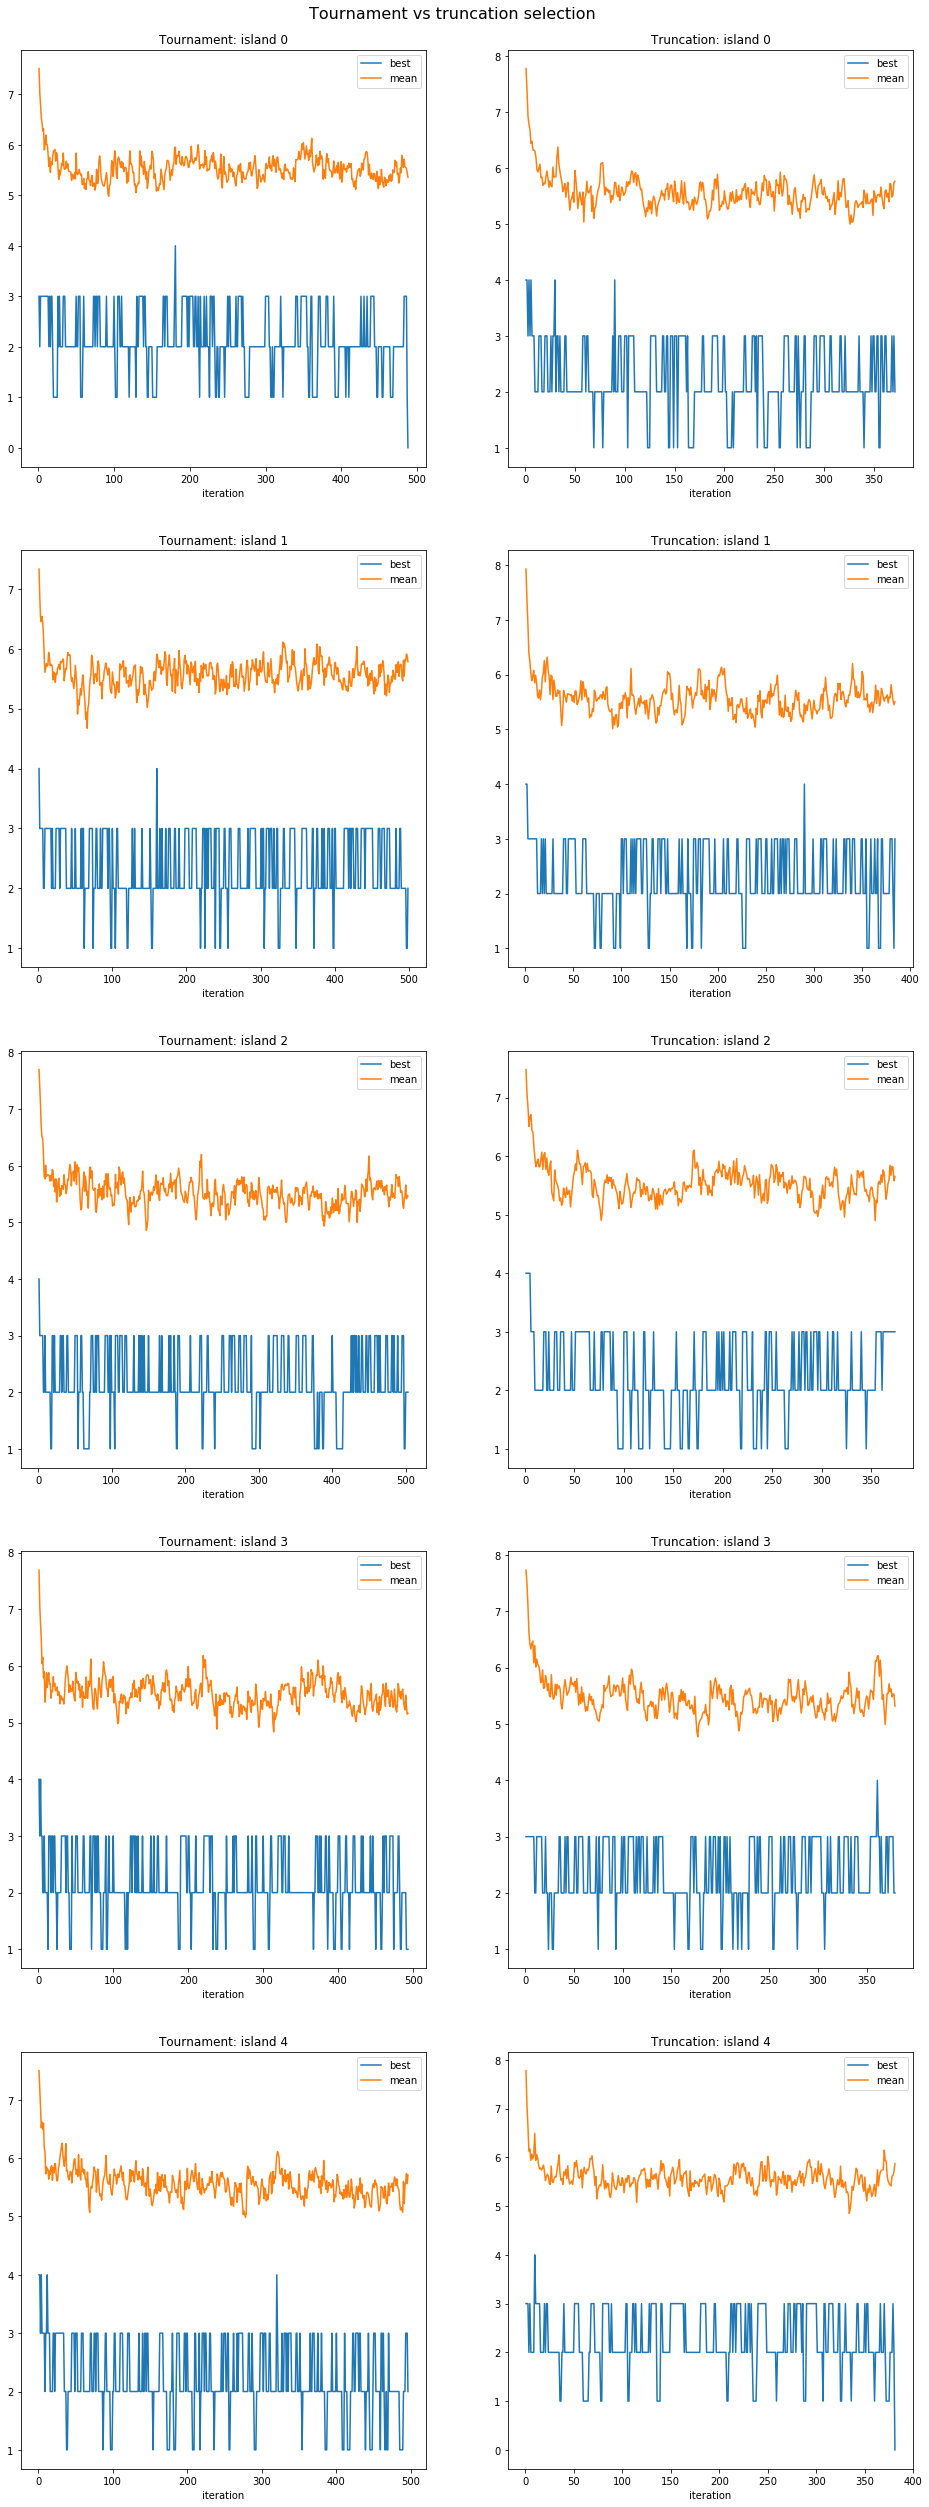

In [6]:
selection_analysis()

## Different island counts [QueensPuzzle]

```kotlin
runBlocking {
    supervisorActor.runSimulation(islandsCount = 5) { results -> // <--
        results
            .sortedBy { it.fitness }
            .take(5)
            .forEach {
                println(it.entity)
                println("F = ${it.fitness}")
            }
    }
}
```

In [7]:
def island_count_analysis():
    totalIslandCounts = [1, 3, 5, 10, 20]
    dfs = []
    for i in totalIslandCounts:
        df = load_dataset(f'queens_tournament_{i}i')
        df = df[['iteration', 'best', 'mean']]
        df = df.groupby(['iteration']).agg(['min', 'mean']).my_flatten_cols()
        df = df[['iteration', 'best_min', 'mean_mean']]
        df['totalIslandCount'] = i
        
        dfs.append(df)
    
    df = pd.concat(dfs)
    
    nrows = len(totalIslandCounts)
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(fig_width, fig_height * nrows))
    fig.suptitle('Different island counts', fontsize=16)
    fig.subplots_adjust(top=.965)
    
    for i, isl in enumerate(totalIslandCounts):
        xdf = df[df.totalIslandCount == isl]
        
        xdf.plot(x='iteration', y='best_min', ax=ax[i, 0], title=f'Best solution: islands {isl}')
        xdf.plot(x='iteration', y='mean_mean', ax=ax[i, 1], title=f'Mean solution: islands {isl}')

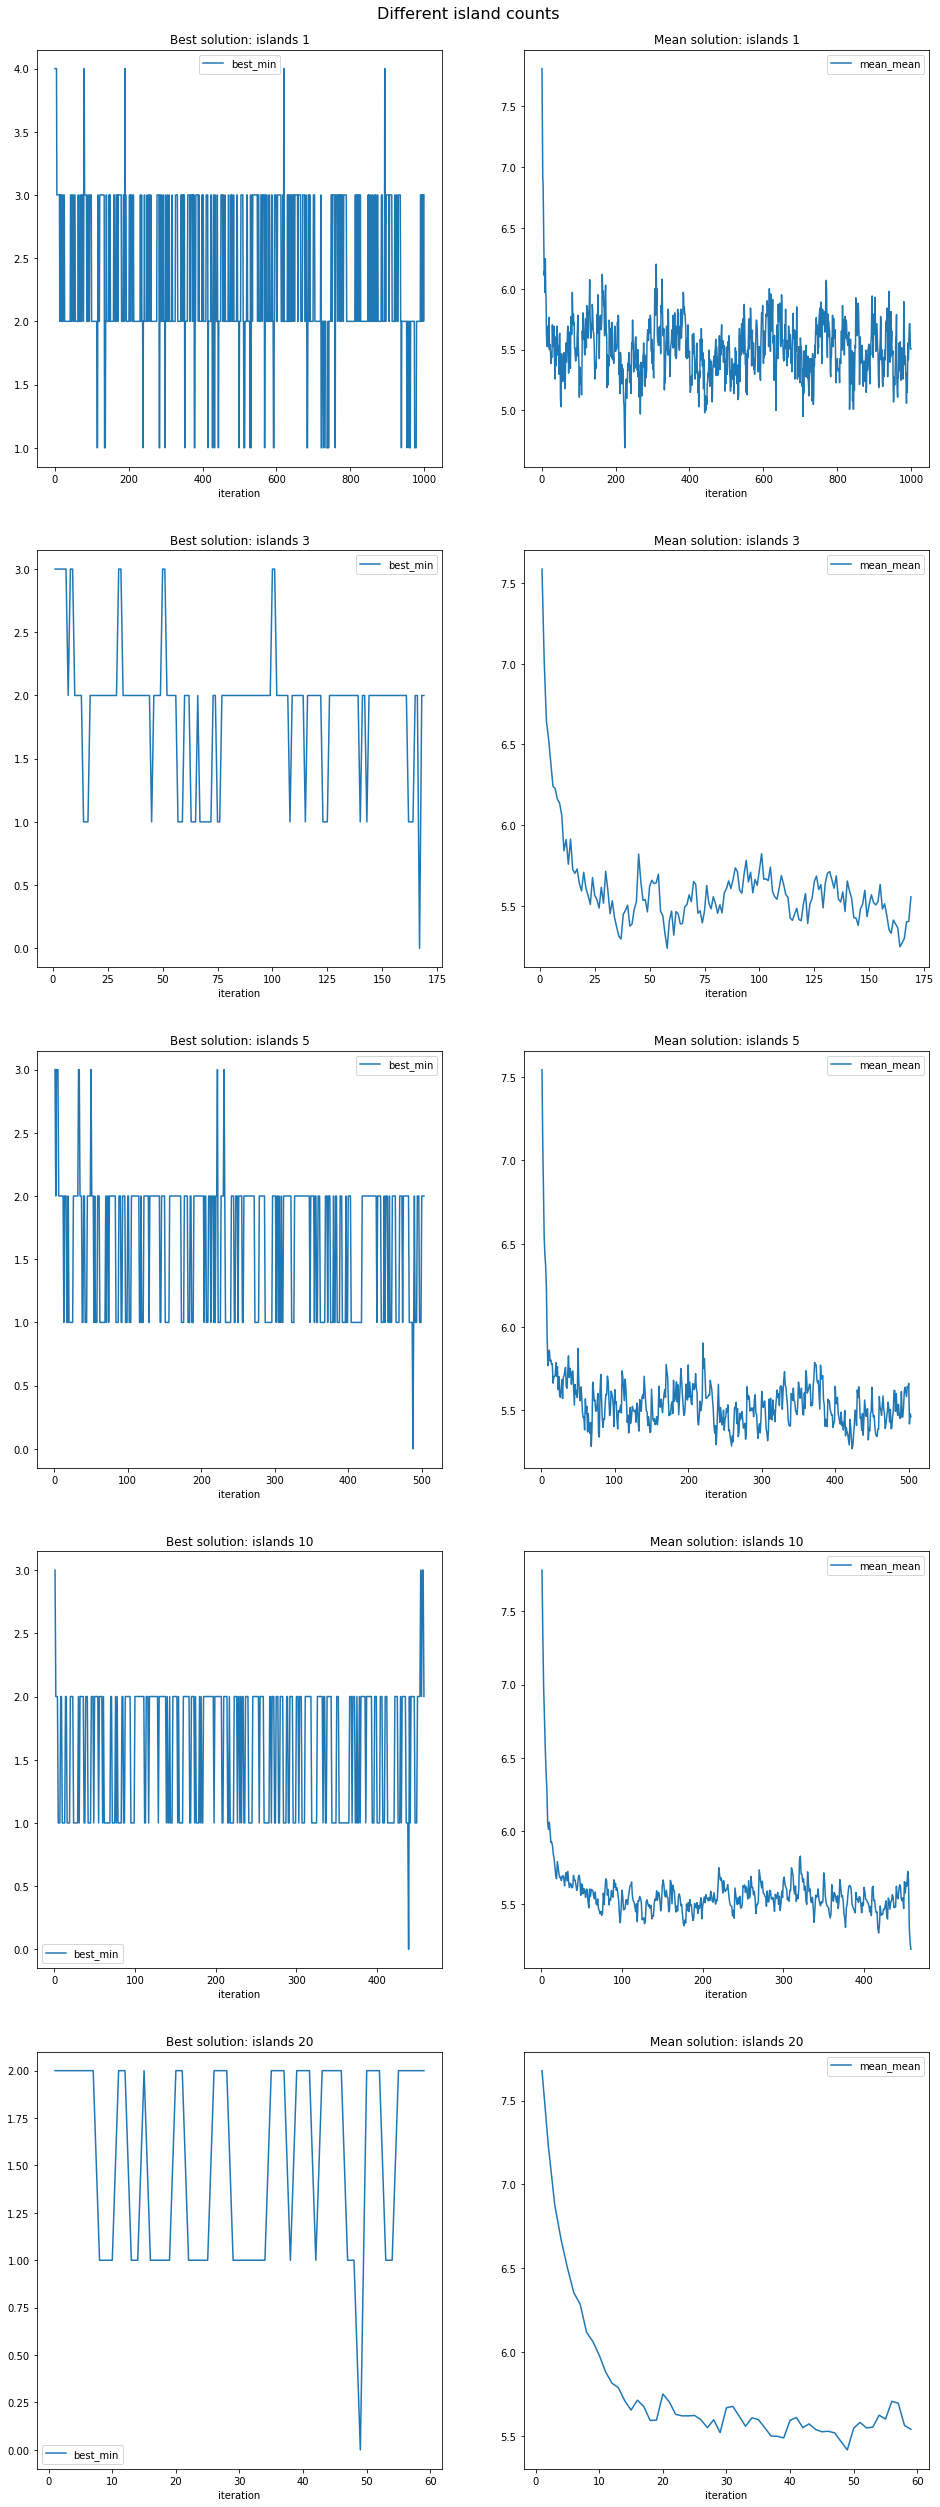

In [8]:
island_count_analysis()

## Random vs truncation (best n) reproduction [OneMax]

```kotlin
class OneMaxBestnPopulationRecombinator(hyperparameters: OneMaxHyperparameters, reporter: Reporter) :
    CouplePopulationRecombinator<BinaryVector, EvaluatedBinaryVector, OneMaxHyperparameters>(
        hyperparameters,
        reporter
    ) {

    override fun recombineCouple(entity1: BinaryVector, entity2: BinaryVector): BinaryVector {
        val cutPoint = Random.nextInt(0, hyperparameters.vectorSize)
        val slice1 = entity1.genes.sliceArray(0 until cutPoint)
        val slice2 = entity2.genes.sliceArray(cutPoint until hyperparameters.vectorSize)

        return BinaryVector(slice1 + slice2)
    }

    override fun selectPopulationToBeRecombined(evaluatedPopulation: EvaluatedPopulation<BinaryVector, EvaluatedBinaryVector>): Population<BinaryVector> {
        val numberOfEntitiesChosenToRecombine =
            (evaluatedPopulation.size * 2 * hyperparameters.reproductionRate).roundToInt()

        val entitiesChosenToRecombine = evaluatedPopulation.evaluatedEntities
            .sortedByDescending { it.numberOfOnes } // <--
            .take(numberOfEntitiesChosenToRecombine)
            .map { it.entity }

        return Population(entitiesChosenToRecombine)
    }
}
```
```kotlin
class OneMaxRandomPopulationRecombinator(hyperparameters: OneMaxHyperparameters, reporter: Reporter) :
    CouplePopulationRecombinator<BinaryVector, EvaluatedBinaryVector, OneMaxHyperparameters>(
        hyperparameters,
        reporter
    ) {

    override fun recombineCouple(entity1: BinaryVector, entity2: BinaryVector): BinaryVector {
        val cutPoint = Random.nextInt(0, hyperparameters.vectorSize)
        val slice1 = entity1.genes.sliceArray(0 until cutPoint)
        val slice2 = entity2.genes.sliceArray(cutPoint until hyperparameters.vectorSize)

        return BinaryVector(slice1 + slice2)
    }

    override fun selectPopulationToBeRecombined(evaluatedPopulation: EvaluatedPopulation<BinaryVector, EvaluatedBinaryVector>): Population<BinaryVector> {
        val numberOfEntitiesChosenToRecombine =
            (evaluatedPopulation.size * 2 * hyperparameters.reproductionRate).roundToInt()

        val entitiesChosenToRecombine = evaluatedPopulation.evaluatedEntities
            .shuffled() // <--
            .take(numberOfEntitiesChosenToRecombine)
            .map { it.entity }

        return Population(entitiesChosenToRecombine)
    }
}
```

In [9]:
def reproduction_analysis():
    tdf = load_dataset('onemax_truncrepr')
    tdf['type'] = 'trunc'
    rdf = load_dataset('onemax_randrepr')
    rdf['type'] = 'rand'
    
    islands = [0, 1, 2, 3, 4]
    nrows =  len(islands)
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(fig_width, fig_height * nrows))
    fig.suptitle('Tournament vs truncation selection', fontsize=16)
    fig.subplots_adjust(top=.965)
    
    for i in islands:
        tdf[tdf.islandId == i].plot(x='iteration', y=['best', 'mean'], ax=ax[i, 0], title=f'Trunc reproduction selection: island {i}')
        rdf[rdf.islandId == i].plot(x='iteration', y=['best', 'mean'], ax=ax[i, 1], title=f'Random reporoduction selection: island {i}')

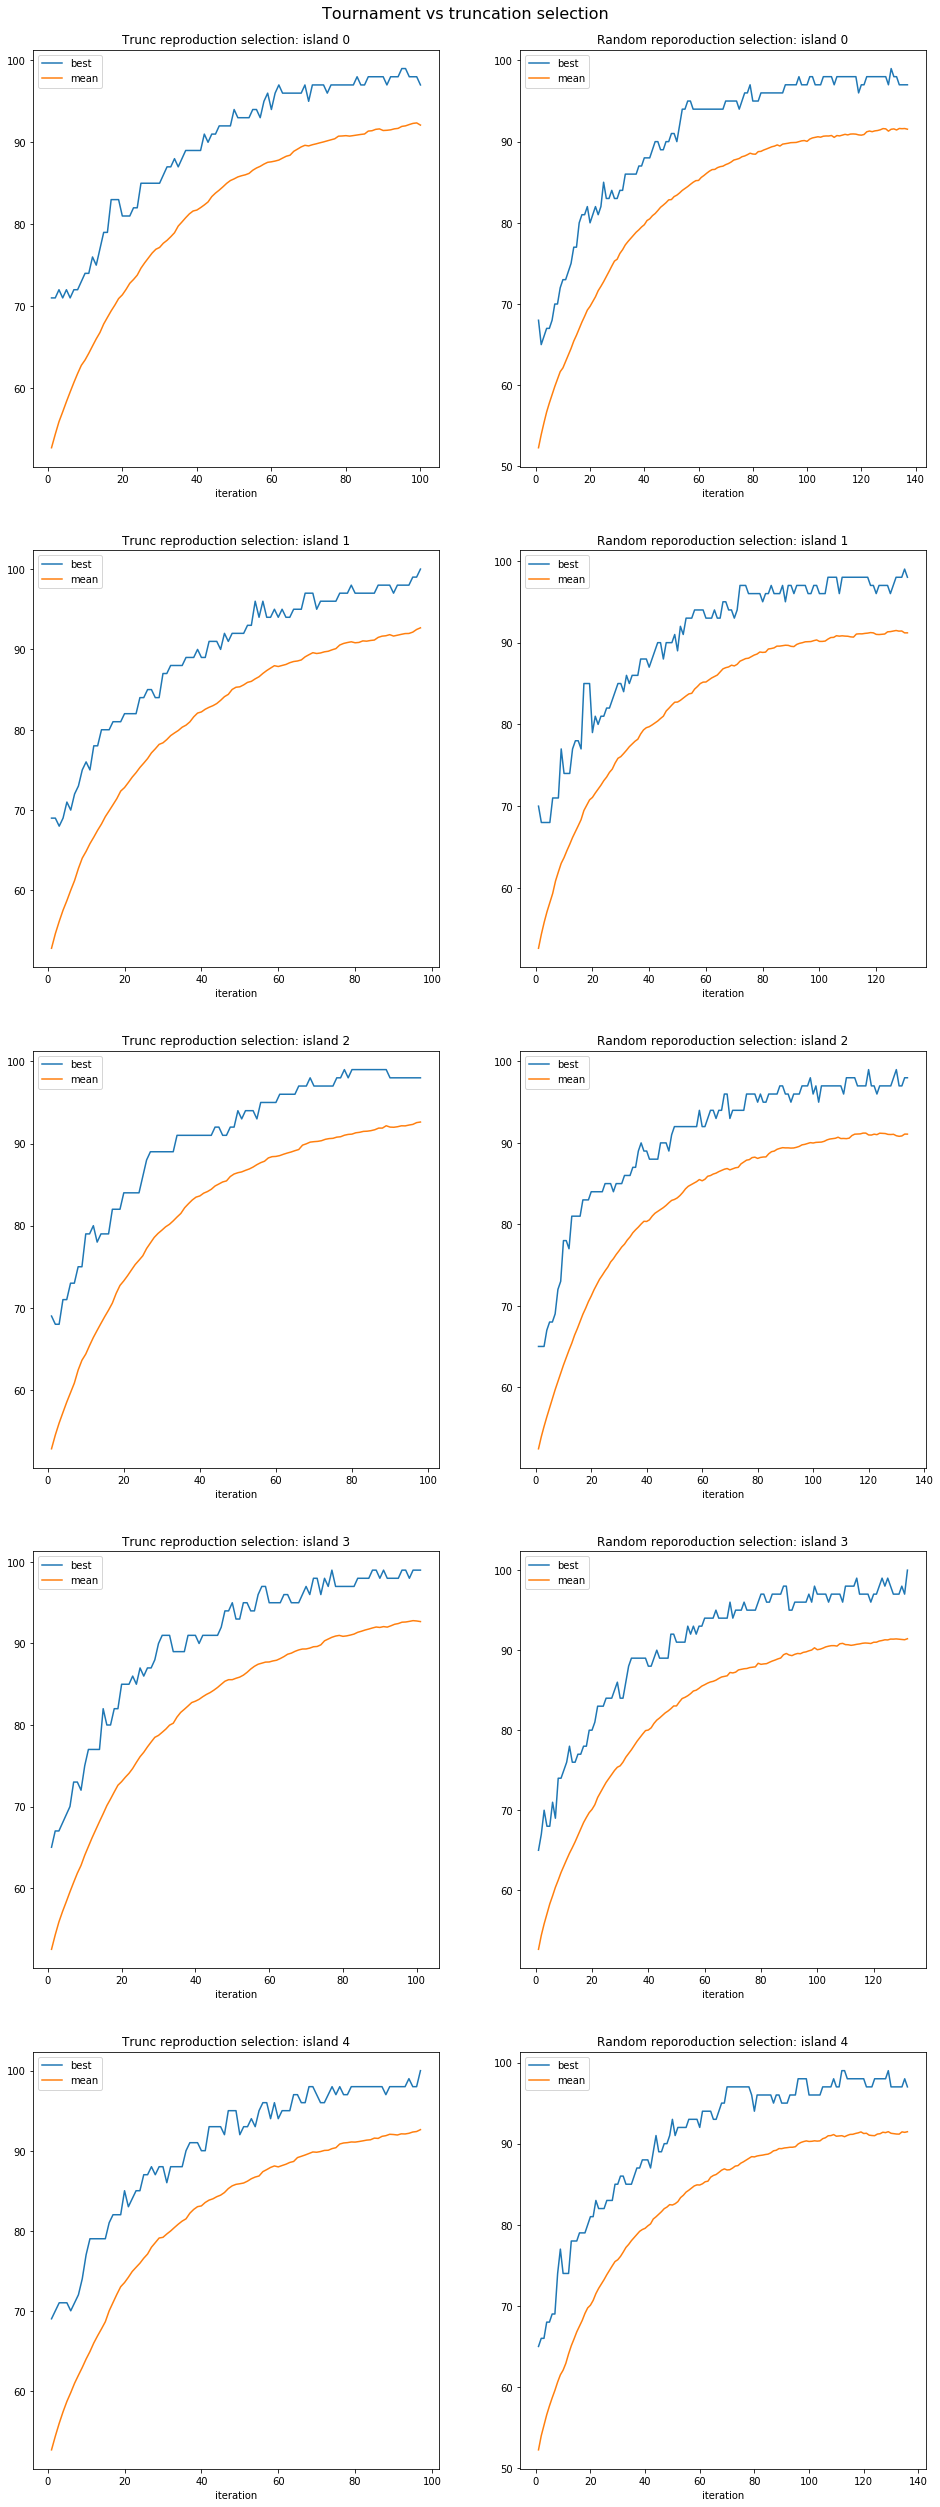

In [10]:
reproduction_analysis()

## Potancjalne ulepszenia
- **Inne topologie migracji**\
    Aktualnie jedyną topologią jest topologia pierścienia.
    Można zaimplementować inne, bardziej zaawansowane topologie i możliwość ich podmiany.
- **Migracje bez `delay()`**\
    Aktualnie, aby wymusić równoległość kodu asynchronicznego po każdej iteracji losujemy bardzo mały delay (0-5ns).
    Nie jest to rozwiązanie najbardziej eleganckie.
    Początkową ideą była idea asynchronicznej migracji, gdzie każdy aktor może dokonać migracji kiedy chce i przyjąć migrantów kiedy chce, lecz to wymaga równoległego działania aktorów, co w przypadku korutyn, a nie osobnych maszyn, czy chociaż wątków wymusza tweaki takie, jak wspomniany delay.
    Można zatem zastanowić się nad synchronicznymi migracjami, które umożliwiałoby nie uruchomienie aktorów nie w pełni równolegle.
- **Możliwość decydowania o mutacjach na podstawie metryk ewaluacji**\
    Aktualnie podczas wykonywania mutacji nie mamy dostępu do informacji o wyniku ewaluacji obiektu.
    Nie da się na przykład zapobiec mutacjom obiektów najlepszych, co mogłoby być porządaną strategią.
    Aby rozwiązać tą kwestię, należy przesłać również wynik ewaluacji do obiektu odpowiedzialnego za mutacje.
- **Rezygnacja z EvaluatedEntity na rzecz leniwie obliczanych (cache-owancyh) wyników ewaluacji**\
    Choć z początku wydawał się mieć rację bytu, w większości praktycznych przypadków obiekt `EvaluatedEntity` wydaje się być zbędny i wprowadzać niepotrzebny szum.
    Możnaby zamiast tworzyć specjalny obiekt na metryki ewaluacji, mieć ten mechanizm zaimplementowany w zwykłym obiekcie modelu.
    Gdyby zadbać też o cachowanie wyniku ewaluacji, to tak jak teraz, mielibyśmy pewność że ewaluujemy obiekt tylko raz.
    Ze względu na zalecaną preferowaną niemutowalność obiektu modelu, nie trzeba by się martwić o aktualność cachowanych metryk.